In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import PowerTransformer



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Funções de suporte




In [ ]:
def check_stationarity(series: pd.Series, seasonal_period: int = None, alpha: float = 0.05):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller test.
    Optionally handle seasonal differencing.

    Parameters:
        series (pd.Series): The input time series.
        seasonal_period (int, optional): Seasonal period (e.g., 12 for monthly).
        alpha (float): Significance level for ADF test.

    Returns:
        dict: {
            'adf_stat': float,
            'p_value': float,
            'stationary': bool,
            'diffs_needed': int,
            'seasonal_diffs_needed': int
        }
    """
    def is_stationary(y):
        result = adfuller(y, autolag='AIC')
        return result[0], result[1], result[1] < alpha

    y = series.dropna()
    if isinstance(series, pd.DataFrame):
        y = series.iloc[:, 0]

    # Check original series
    adf_stat, p_val, stationary = is_stationary(y)
    if stationary:
        return {
            'adf_stat': adf_stat,
            'p_value': p_val,
            'stationary': True,
            'diffs_needed': 0,
            'seasonal_diffs_needed': 0
        }

    # Seasonal differencing
    seasonal_diffs = 0
    if seasonal_period:
        for s in range(1, 3):  # try 1 or 2 seasonal diffs
            y_seasonal = y.diff(seasonal_period * s).dropna()
            adf_stat, p_val, stationary = is_stationary(y_seasonal)
            if stationary:
                return {
                    'adf_stat': adf_stat,
                    'p_value': p_val,
                    'stationary': True,
                    'diffs_needed': 0,
                    'seasonal_diffs_needed': s
                }

    # Try both seasonal + regular differencing
    if seasonal_period:
        y_combo = y.copy()
        for s in range(1, 3):
            for d in range(1, 3):
                y_combo = y.diff(seasonal_period * s).dropna().diff(d).dropna()
                adf_stat, p_val, stationary = is_stationary(y_combo)
                if stationary:
                    return {
                        'adf_stat': adf_stat,
                        'p_value': p_val,
                        'stationary': True,
                        'diffs_needed': d,
                        'seasonal_diffs_needed': s
                    }

    # Regular differencing
    diffs = 0
    y_diff = y.copy()
    while diffs < 3:
        y_diff = y_diff.diff().dropna()
        adf_stat, p_val, stationary = is_stationary(y_diff)
        diffs += 1
        if stationary:
            return {
                'adf_stat': adf_stat,
                'p_value': p_val,
                'stationary': True,
                'diffs_needed': diffs,
                'seasonal_diffs_needed': 0
            }


    # If nothing worked
    return {
        'adf_stat': adf_stat,
        'p_value': p_val,
        'stationary': False,
        'diffs_needed': diffs,
        'seasonal_diffs_needed': seasonal_diffs
    }


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from multiprocessing import Pool, cpu_count
from typing import Union
from tqdm.notebook import tqdm

# Define your function to run in parallel
def fit_sarima(args):
    endog, order, d, D, s = args
    try:
        model = SARIMAX(
            endog,
            order=(order[0], d, order[1]),
            seasonal_order=(order[2], D, order[3], s),
            simple_differencing=False
        ).fit(disp=False)
        return (order, model.aic)
    except:
        return None
    pass

def optimize_SARIMA_parallel(endog, order_list, d, D, s):
    # Prepare arguments for parallel execution
    args_list = [(endog, order, d, D, s) for order in order_list]
    print(cpu_count())
    # Set up multiprocessing pool
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(fit_sarima, args_list), total=len(order_list)))

    # Filter out failed attempts (None)
    results = [res for res in results if res is not None]

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np

def check_white_noise(residuals: pd.Series, lags: int = 20, alpha: float = 0.05):
    """
    Check if residuals and squared residuals are white noise using the Ljung-Box test.

    Parameters:
        residuals (pd.Series): Residuals from a model.
        lags (int): Number of lags to test.
        alpha (float): Significance level.

    Returns:
        dict: {
            'residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            },
            'squared_residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            }
        }
    """
    # Drop NaNs just in case
    residuals = pd.Series(residuals).dropna()
    squared_residuals = residuals**2

    # Ljung-Box on residuals
    lb_resid = acorr_ljungbox(residuals, lags=lags, return_df=True)
    resid_pvals = lb_resid['lb_pvalue']
    resid_failed = (resid_pvals < alpha).sum()

    # Ljung-Box on squared residuals
    lb_sq = acorr_ljungbox(squared_residuals, lags=lags, return_df=True)
    sq_pvals = lb_sq['lb_pvalue']
    sq_failed = (sq_pvals < alpha).sum()

    return {
        'residuals': {
            'p_values': resid_pvals,
            'lags_failed': resid_failed
        },
        'squared_residuals': {
            'p_values': sq_pvals,
            'lags_failed': sq_failed
        }
    }


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_model_mape(test_df, actual_col, pred_cols, title="Model Comparison (MAPE %)"):
    """
    Plots a bar chart of MAPE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    mape_scores = [mape(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, mape_scores, width=0.6, edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, max(mape_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(mape_scores):
        ax.text(i, val + 0.5, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, mape_scores))


In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_model_rmse(test_df, actual_col, pred_cols, title="Model Comparison (RMSE)"):
    """
    Plots a bar chart of RMSE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    rmse_scores = [rmse(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, rmse_scores, width=0.6, color='lightcoral', edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')
    ax.set_ylim(0, max(rmse_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(rmse_scores):
        ax.text(i, val + max(rmse_scores) * 0.03, f"{val:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, rmse_scores))


# Seleção de modelo

## Conjunto de treino

In [ ]:
df = pd.read_excel('/content/DadosCompeticao.xlsx', decimal=',')
serie_2 = df.iloc[:, 1]
serie_2.head()

,#2
0,0.032171
1,0.042471
2,0.036363
3,0.035029
4,0.033270


In [ ]:
test = pd.DataFrame()
test["Values"] = serie_2.iloc[-12:]
test['naive_seasonal'] = serie_2.iloc[-24:-12].values
test['naive_seasonal-A'] = serie_2.iloc[-24:-12].mean()

## Análise exploratória

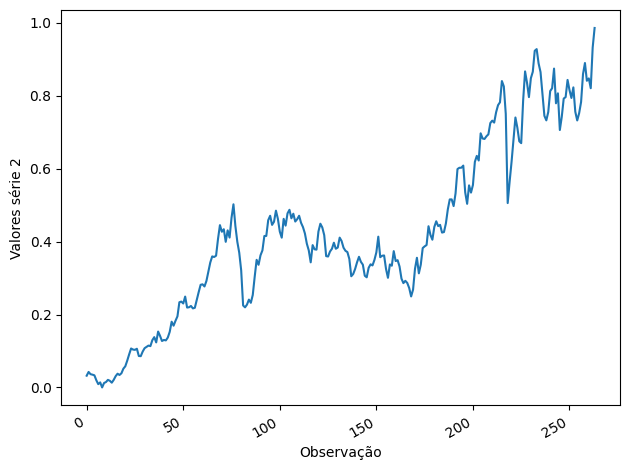

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_2)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores série 2')

fig.autofmt_xdate()
plt.tight_layout()


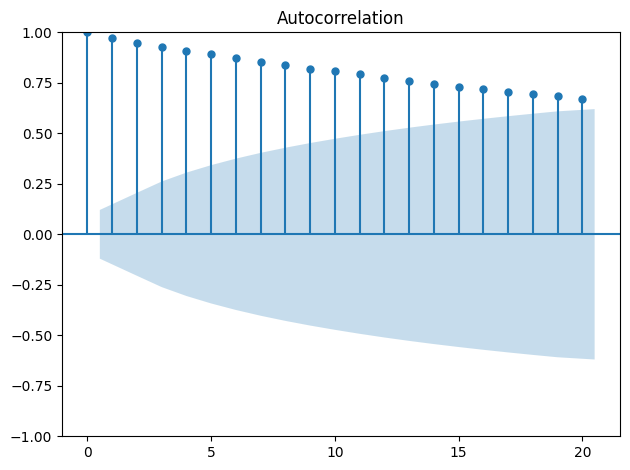

In [ ]:
plot_acf(serie_2, lags=20);

plt.tight_layout()

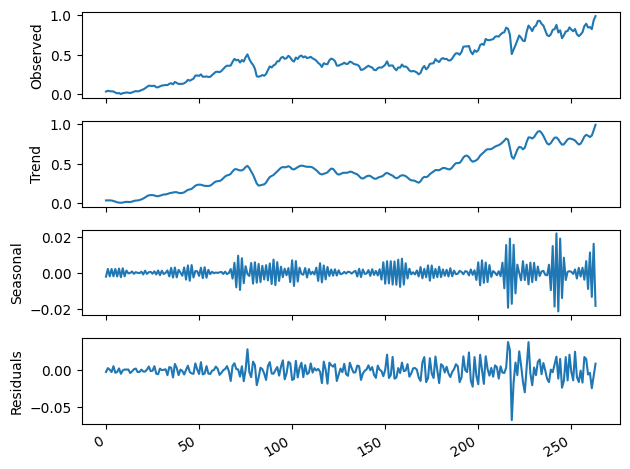

In [ ]:
advanced_decomposition = STL(serie_2,period=2).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

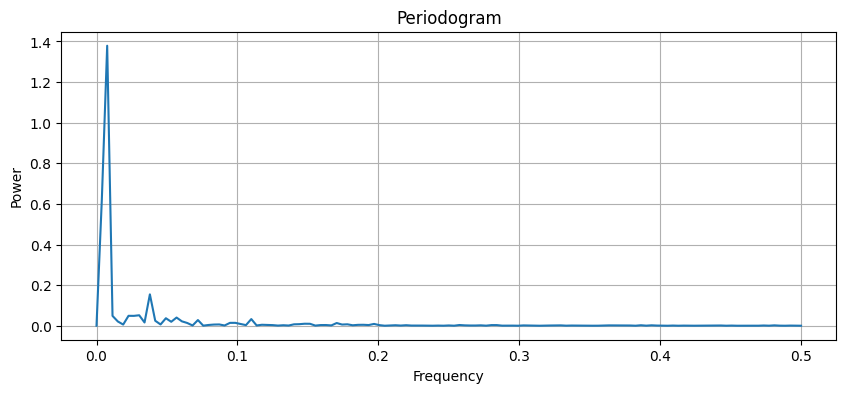

In [ ]:
from scipy.signal import periodogram

freqs, psd = periodogram(serie_2, detrend='linear')
plt.figure(figsize=(10, 4))
plt.plot(freqs, psd)
plt.title("Periodogram")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.show()


## ARIMA

In [ ]:
check_stationarity(serie_2)

{'adf_stat': np.float64(-9.964828170742019),
 'p_value': np.float64(2.3218933617456268e-17),
 'stationary': True,
 'diffs_needed': 1,
 'seasonal_diffs_needed': 0}

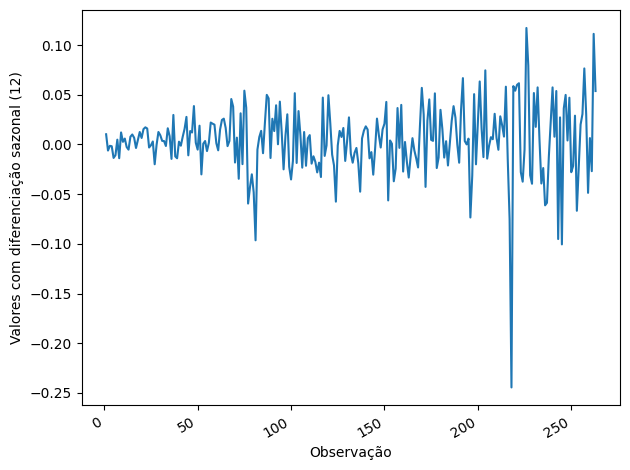

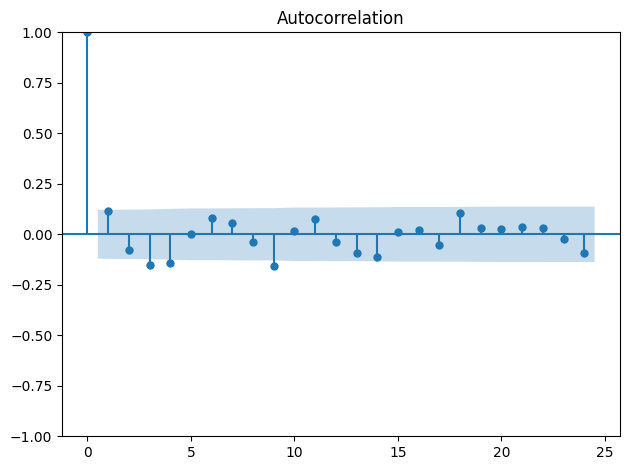

In [ ]:
seasonal_diff = serie_2.diff().dropna()
fig, ax = plt.subplots()

ax.plot(seasonal_diff)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores com diferenciação sazonal (12)')

fig.autofmt_xdate()
plt.tight_layout()
plot_acf(seasonal_diff, lags=24);
plt.tight_layout()

### Treinamento


```
 from itertools import product

d, D, s = 1, 0, 0
ps = qs = range(0, 12)
Ps = Qs = [0]

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = serie_1[:-12]

 SARIMA_result_df = optimize_SARIMA_parallel(train, SARIMA_order_list, d, D, s)
 SARIMA_result_df
 */

```
Modelos selecionados:  \\

* ARIMA(5,1,2) | AIC = -1191.732103 \\

In [ ]:
train = serie_2[:-12]
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

ARIMA_model = SARIMAX(train_transformed, order=(4,1,2), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)


SARIMA_model = SARIMAX(train_transformed, order=(4,0,4), seasonal_order=(2,0,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)


print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(4, 1, 2)   Log Likelihood                 598.696
Date:                Tue, 29 Apr 2025   AIC                          -1183.392
Time:                        17:27:30   BIC                          -1158.714
Sample:                             0   HQIC                         -1173.461
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6022      0.409      3.918      0.000       0.801       2.404
ar.L2         -1.0193      0.370     -2.754      0.006      -1.745      -0.294
ar.L3          0.1522      0.155      0.984      0.3

In [ ]:
forecast_ARIMA = ARIMA_model_fit.forecast(steps=12)
test['ARIMA_pred'] = pt.inverse_transform(forecast_ARIMA.values.reshape(-1, 1)).flatten()

In [ ]:
forecast_SARIMA = SARIMA_model_fit.forecast(steps=12)
test['SARIMA_pred'] = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()

### Análise de resíduos

In [ ]:
check_white_noise(ARIMA_model_fit.resid, lags = 24)

{'residuals': {'p_values': 1     0.916491
  2     0.984215
  3     0.977695
  4     0.973539
  5     0.974542
  6     0.989131
  7     0.991954
  8     0.914025
  9     0.373475
  10    0.453339
  11    0.457781
  12    0.543633
  13    0.503967
  14    0.413610
  15    0.458758
  16    0.510345
  17    0.477761
  18    0.389066
  19    0.393530
  20    0.454832
  21    0.462273
  22    0.514623
  23    0.574664
  24    0.516257
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(0)},
 'squared_residuals': {'p_values': 1     0.015584
  2     0.053606
  3     0.095676
  4     0.156970
  5     0.242651
  6     0.347176
  7     0.458219
  8     0.071726
  9     0.098885
  10    0.136662
  11    0.187393
  12    0.246614
  13    0.312234
  14    0.259423
  15    0.315141
  16    0.369395
  17    0.398493
  18    0.452382
  19    0.482179
  20    0.547349
  21    0.607445
  22    0.508056
  23    0.563476
  24    0.620879
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64

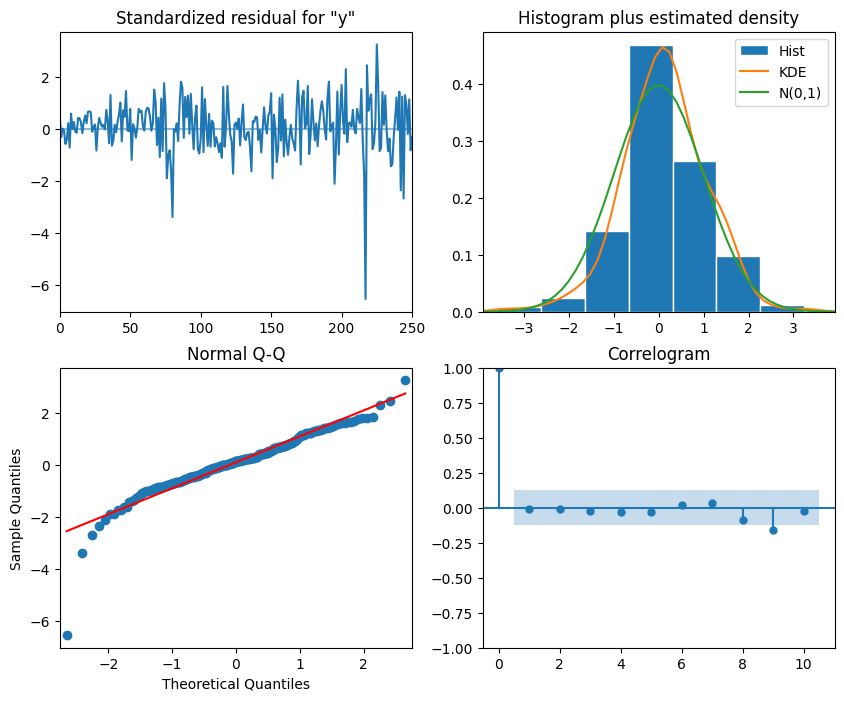

In [ ]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

## Holt-Winters

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

train = serie_2[:-12]
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)
ES = ExponentialSmoothing(train_transformed,trend='add')
ES_fit = ES.fit()
forecast_1 =  pt.inverse_transform(ES_fit.forecast(12).values.reshape(-1, 1)).flatten()

ES3 = ExponentialSmoothing(train, trend='add')
ES3_fit = ES3.fit()

test["HW"] = forecast_1
test["HW_P"] = ES3_fit.forecast(12).values
test


,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P
252,0.822791,0.812688,0.798498,0.787840,0.796346,0.797689,0.796804
253,0.756070,0.820523,0.798498,0.785883,0.808756,0.801611,0.799831
254,0.732126,0.874353,0.798498,0.785935,0.799974,0.805540,0.802859
255,0.752145,0.779182,0.798498,0.787430,0.794377,0.809479,0.805886
256,0.782786,0.806463,0.798498,0.789565,0.788574,0.813425,0.808914
257,0.859343,0.705906,0.798498,0.791499,0.782671,0.817380,0.811941
258,0.889615,0.742199,0.798498,0.792648,0.785070,0.821344,0.814969
259,0.840934,0.792112,0.798498,0.792819,0.792243,0.825316,0.817996
260,0.847395,0.796147,0.798498,0.792184,0.798514,0.829297,0.821024
261,0.820538,0.843250,0.798498,0.791139,0.805743,0.833286,0.824051


In [ ]:
ES_fit.summary()

Dep. Variable:,None,No. Observations:,252
Model:,ExponentialSmoothing,SSE,0.127
Optimized:,True,AIC,-1905.420
Trend:,Additive,BIC,-1891.302
Seasonal:,None,AICC,-1905.077
Seasonal Periods:,None,Date:,"Tue, 29 Apr 2025"
Box-Cox:,False,Time:,17:27:31
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,2.9497e-17,beta,True


## Theta

In [ ]:
from statsmodels.tsa.forecasting.theta import ThetaModel

pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

# Fit the Theta model
theta_model = ThetaModel(train_transformed,period=12,difference=True)
theta_fit = theta_model.fit()

# Forecast future values
theta_forecast = theta_fit.forecast(steps=12)
test["Theta"] = pt.inverse_transform(theta_forecast.values.reshape(-1, 1)).flatten()
# Print results
print(theta_fit.summary())
print("Forecast:", theta_forecast)

                              ThetaModel Results                              
Dep. Variable:                  endog   No. Observations:                  252
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 29 Apr 2025   Deseas. Method:               Additive
Time:                        17:27:31   Period:                             12
Sample:                             0                                         
                                  252                                         
   Parameter Estimates    
           Parameters     
--------------------------
b0    0.002012264916601805
alpha    0.999828579094836
--------------------------
Forecast: 252    0.588185
253    0.589191
254    0.590197
255    0.591203
256    0.592209
257    0.593216
258    0.594222
259    0.595228
260    0.596234
261    0.597240
262    0.598246
263    0.599252
Name: forecast, dtype: float64


## Visualização das predições

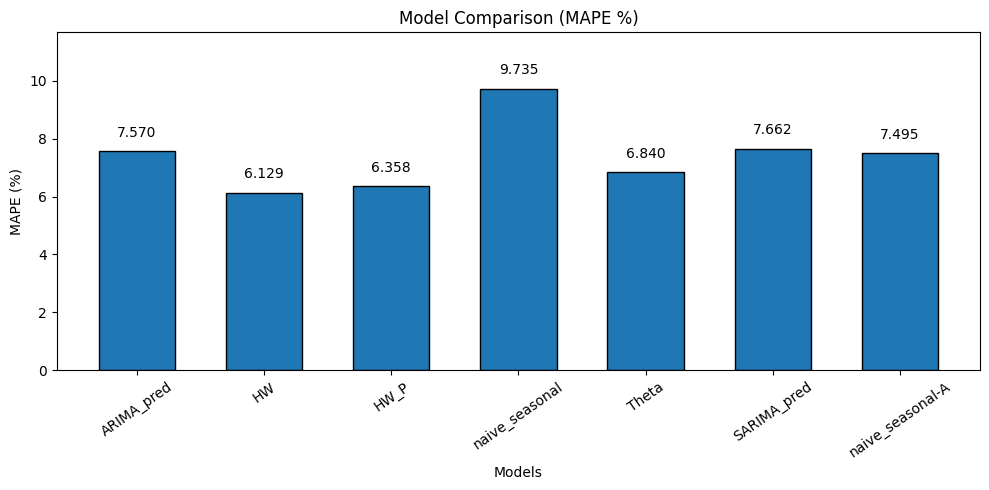

{'ARIMA_pred': np.float64(7.569874872422178),
 'HW': np.float64(6.1290699850243415),
 'HW_P': np.float64(6.35844756660056),
 'naive_seasonal': np.float64(9.735303855139412),
 'Theta': np.float64(6.839823399088725),
 'SARIMA_pred': np.float64(7.662334945159431),
 'naive_seasonal-A': np.float64(7.494576408504053)}

In [ ]:
columns = ['ARIMA_pred','HW','HW_P','naive_seasonal','Theta','SARIMA_pred','naive_seasonal-A']
plot_model_mape(test,'Values',columns)

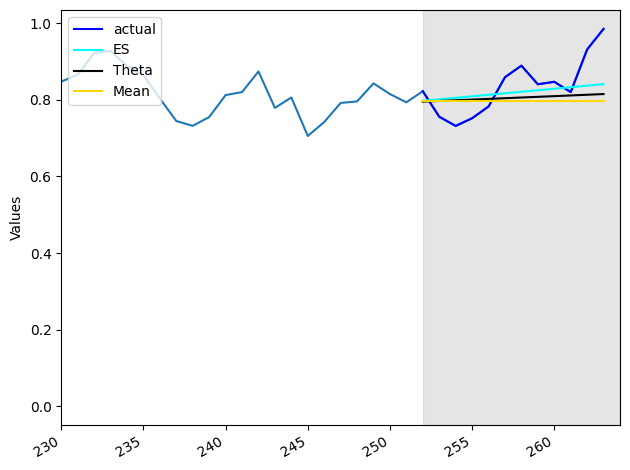

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_2)
ax.plot(test["Values"], 'b-', label='actual')
#ax.plot(test['ARIMA_pred'], 'g-.', label='ARIMA(2,1,4)')
ax.plot(test['HW'], 'cyan', label='ES')
ax.plot(test['Theta'], 'black', label='Theta')
#ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['naive_seasonal-A'] , 'gold', label='Mean')

ax.set_ylabel('Values')
ax.axvspan(252, 264, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(230, 264)

fig.autofmt_xdate()
plt.tight_layout()

# Métricas finais

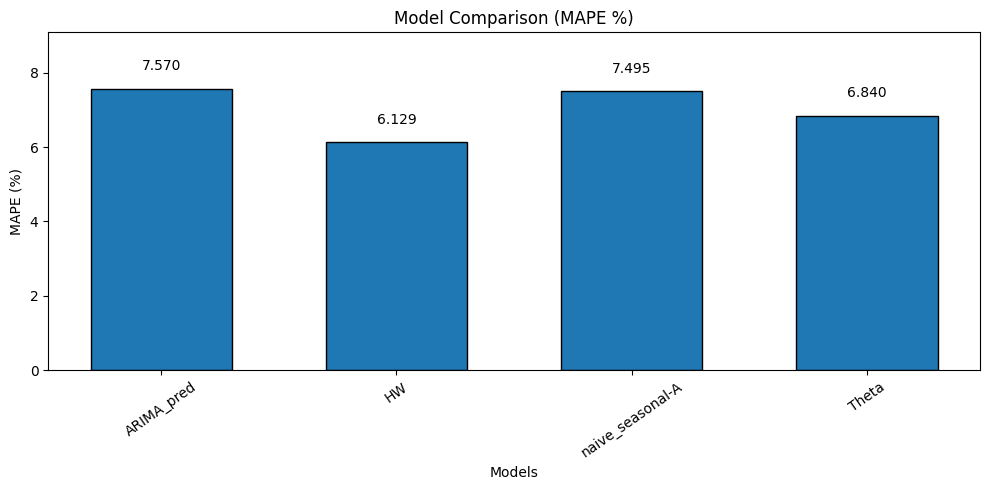

{'ARIMA_pred': np.float64(7.569874872422178),
 'HW': np.float64(6.1290699850243415),
 'naive_seasonal-A': np.float64(7.494576408504053),
 'Theta': np.float64(6.839823399088725)}

In [ ]:
test['naive_seasonal-A'] = serie_2.iloc[-24:-12].mean()
columns = ['ARIMA_pred','HW','naive_seasonal-A','Theta']
plot_model_mape(test,'Values',columns)

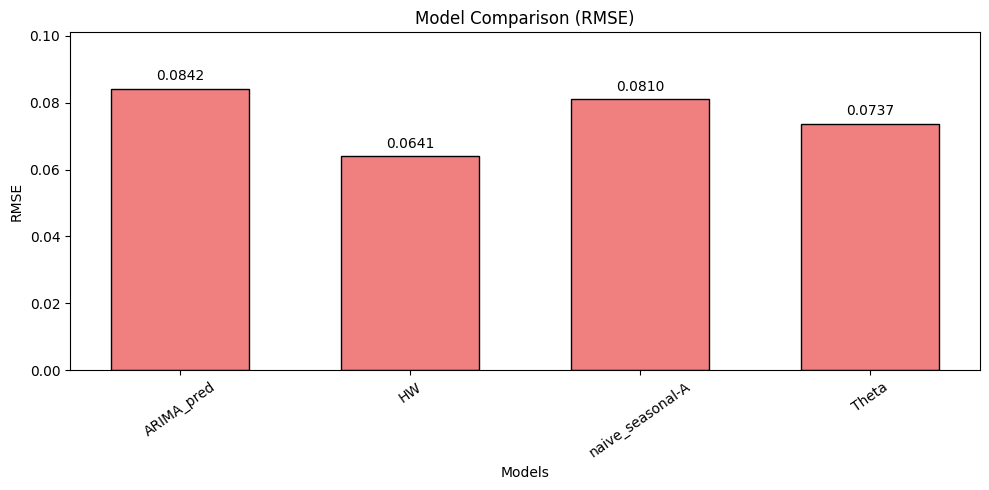

{'ARIMA_pred': np.float64(0.08423876596724894),
 'HW': np.float64(0.064089814536091),
 'naive_seasonal-A': np.float64(0.08099629953475083),
 'Theta': np.float64(0.07373836709225563)}

In [ ]:
test['naive_seasonal-A'] = serie_2.iloc[-24:-12].mean()
columns = ['ARIMA_pred','HW','naive_seasonal-A','Theta']
plot_model_rmse(test,'Values',columns)

# Previsão para a série (próximos 12 meses)

In [ ]:

pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(serie_2.values.reshape(-1, 1)).flatten(), index=serie_2.index)
ES = ExponentialSmoothing(train_transformed,trend='add')
ES_fit = ES.fit()
forecast =  pt.inverse_transform(ES_fit.forecast(12).values.reshape(-1, 1)).flatten()
forecast


array([0.99062223, 0.99553622, 1.00046201, 1.00539963, 1.0103491 ,
       1.01531046, 1.02028372, 1.02526892, 1.03026608, 1.03527523,
       1.04029641, 1.04532963])

In [ ]:
# ----- Salvando previsões numeradas em um .txt -----
horizon = len(forecast)
with open("forecast_HW.txt", "w") as f:
    for i, value in enumerate(forecast, 1):
        f.write(f"{value:};\n")